In [2]:
import joblib

model_folder = '../models_seq2seq/'

model_mar = joblib.load(model_folder+f'mar_rf_model.joblib')
model_jul = joblib.load(model_folder+f'jul_rf_model.joblib')
model_nov = joblib.load(model_folder+f'nov_rf_model.joblib')

scalers_mar = joblib.load(model_folder+f'mar_scalers_data.joblib')
scalers_jul = joblib.load(model_folder+f'jul_scalers_data.joblib')
scalers_nov = joblib.load(model_folder+f'nov_scalers_data.joblib')

In [3]:
import pandas as pd
data = pd.read_csv("../data/decomp/kusok_1.csv")  # Загрузить файл
hist = data[['full_date', '1']]
hist = hist.loc[hist['full_date'] > '2018-03-15']

In [ ]:
import numpy as np
import pandas as pd
from itertools import cycle
from sklearn.preprocessing import StandardScaler

# ─── your preprocessing & feature functions (as you provided) ─────────────────

def create_date_features(dates_series):
    df = pd.DataFrame(index=dates_series)
    df['day_of_week'] = df.index.dayofweek
    df['month']       = df.index.month
    df['day_of_year'] = df.index.dayofyear
    for feat, period in [('day_of_week',7), ('month',12), ('day_of_year',365)]:
        df[f'{feat}_sin'] = np.sin(2*np.pi*df[feat]/period)
        df[f'{feat}_cos'] = np.cos(2*np.pi*df[feat]/period)
    return df.drop(columns=['day_of_week','month','day_of_year']).values

def preprocess_samples(samples_dict, data_scaler=None, y_scaler=None, fit_scalers=True):
    X_data, X_dates, y = [], [], []

    for key, df in samples_dict.items():
        # automatically find the single “value” column:
        val_cols = [c for c in df.columns if c != 'full_date']
        if len(val_cols) != 1:
            raise ValueError(f"Expected exactly one data column in {key}, got {val_cols}")
        col = val_cols[0]

        values = df[col].values
        dates  = pd.to_datetime(df['full_date'])

        # split into X (first 245) and y (next 120)
        X_data.append(values[:245])
        y.append(values[245:245+120])

        # date-features for the forecast period
        X_dates.append(create_date_features(dates)[245:245+120])

    X_data = np.array(X_data)[..., np.newaxis]
    X_dates = np.array(X_dates)
    y = np.array(y)

    if fit_scalers:
        data_scaler = StandardScaler().fit(X_data.reshape(-1,1))
        y_scaler    = StandardScaler().fit(y)

    X_data = data_scaler.transform(X_data.reshape(-1,1)).reshape(X_data.shape)
    y_scaled = y_scaler.transform(y)

    return (X_data, X_dates, y_scaled), data_scaler, y_scaler


# ─── helper to slice out each seasonal window ──────────────────────────────────

def make_window(df, start_idx, input_size=245):
    w = df.iloc[start_idx:start_idx+input_size].copy()
    # rename the value column to the sample key
    w = w.rename(columns={'value': f'sample_{start_idx}'})
    return {f'sample_{start_idx}': w}

def make_inputs_for_forecast(hist_df, input_size=245, forecast_size=120,
                             data_scaler=None):
    # 1) last 245 values → X_data
    raw_vals = hist_df['value'].iloc[-input_size:].values
    X_data = raw_vals.reshape(1, input_size, 1)                  # (1,245,1)
    X_data = raw_vals.reshape(input_size, 1)                  # (1,245,1)
    X_data_scaled = data_scaler.transform(X_data.reshape(-1,1)) \
                             .reshape(input_size, 1)
                            #  .reshape(1, input_size, 1)

    # 2) next 120 dates → X_dates
    last_date   = pd.to_datetime(hist_df['full_date'].iloc[-1])
    future_dates= pd.date_range(last_date+pd.Timedelta(days=1),
                                periods=forecast_size)
    X_dates     = create_date_features(future_dates)            # (120,6)
    X_dates     = X_dates[None, ...]                            # (1,120,6)

    return X_data_scaled, X_dates

def prepare_traditional_data(X_data, X_dates):
    """Flatten data for traditional ML models"""
    # Flatten time series data and date features
    X_flat = np.concatenate([
        X_data.reshape(X_data.shape[0], -1),  # Flatten time series (245,1) -> 245
        X_dates.reshape(X_dates.shape[0], -1) # Flatten dates (120,6) -> 720
    ], axis=1)
    return X_flat


# ─── train your three seasonal models ───────────────────────────────────────────

# assume `df` has columns ['full_date','value'] sorted by date, length >=365
# e.g. df = pd.DataFrame({'full_date':pd.date_range(...), 'value':your_series})

# ─── iterative rolling‐forecast function ────────────────────────────────────────

def rolling_forecast(models, scalers, history_df,
                     input_size=245, forecast_size=120,
                     n_cycles=3):
    """
    models:  [m1,m2,m3]
    scalers: [{'data':ds1,'y':ys1}, …]   aligned with models
    history_df: DataFrame with ['full_date','value']  (initial history)
    """
    preds = []
    hist = history_df.copy().reset_index(drop=True)
    for model, scaler in zip(cycle(models), cycle(scalers)):
        # grab the last input_size + forecast_size rows
        X_flat = make_inputs_for_forecast(hist, data_scaler=scaler['data'])
        print(X_flat.shape)
        y_hat_scaled = model.predict(X_flat)    # shape (1,120)
        y_hat = scaler['y'].inverse_transform(y_hat_scaled).ravel()

        preds.extend(y_hat)
        # append forecasts back onto hist
        last_date = pd.to_datetime(hist['full_date'].iloc[-1])
        next_dates= pd.date_range(last_date+pd.Timedelta(days=1),
                                  periods=forecast_size)
        new_df   = pd.DataFrame({
            'full_date': next_dates,
            'value':     y_hat
        })
        hist = pd.concat([hist, new_df], ignore_index=True)
        if len(preds) >= n_cycles*forecast_size:
            break
    return np.array(preds)

def rolling_forecast(models, scalers, history_df,
                     input_size=245, forecast_size=120,
                     return_inputs=False):
    preds = []
    X_data_list = []
    y_true_list = []
    hist = history_df.copy().reset_index(drop=True)
    required_steps = history_df.shape[0] - input_size

    # TODO: here should be another cycle. 
    while len(preds) < required_steps:
        for model, scaler in zip(cycle(models), cycle(scalers)):
            # grab the last 245 
            window = make_window(hist, len(hist) - input_size) 
            # we should preprocess test data with training scalers
            (X_d, X_t, _), ds, ys = preprocess_samples(
                window,
                data_scaler=scaler['data'],
                y_scaler=scaler['y'],
                fit_scalers=False
            )

            X_flat = prepare_traditional_data(X_d, X_t)

            y_hat_scaled = model.predict(X_flat)
            y_hat = ys.inverse_transform(y_hat_scaled).ravel()
            preds.extend(y_hat)

            if return_inputs:
                X_data_list.append(X_d[0])  

                # —— pull only the numeric true values ——
                key = list(window.keys())[0]
                df_w = window[key]
                val_col = [c for c in df_w.columns if c != 'full_date'][0]
                true_vals = df_w[val_col].iloc[input_size:input_size+forecast_size].values
                y_true_list.append(true_vals)

            # append forecast to history
            last_date = pd.to_datetime(hist['full_date'].iloc[-1])
            next_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=forecast_size)
            new_df = pd.DataFrame({'full_date': next_dates, 'value': y_hat})
            hist = pd.concat([hist, new_df], ignore_index=True)

    if return_inputs:
        return np.array(preds), np.array(X_data_list), np.array(y_true_list)
    return np.array(preds)



In [ ]:
# ─── run it ───────────────────────────────────────────────────────────────────
# history begins at march 16th 2018. so first model is march, then jul, nov. 
history_df = hist.rename(columns={'1':'value'})

scaler_list = [
    {'data':scalers_mar[0],'y':scalers_mar[1]},
    {'data':scalers_jul[0],'y':scalers_jul[1]},
    {'data':scalers_nov[0],'y':scalers_nov[1]},
]

preds, X_inputs, y_true_lst = rolling_forecast([model_mar, model_jul, model_nov], 
                          scaler_list, 
                          history_df=history_df[:365],
                          input_size=245,
                          forecast_size=120,
                          n_cycles=3, 
                          return_inputs=True)

Overall MSE : 3053.9242
Overall MAE : 42.3746
Overall MAPE: 63.66%


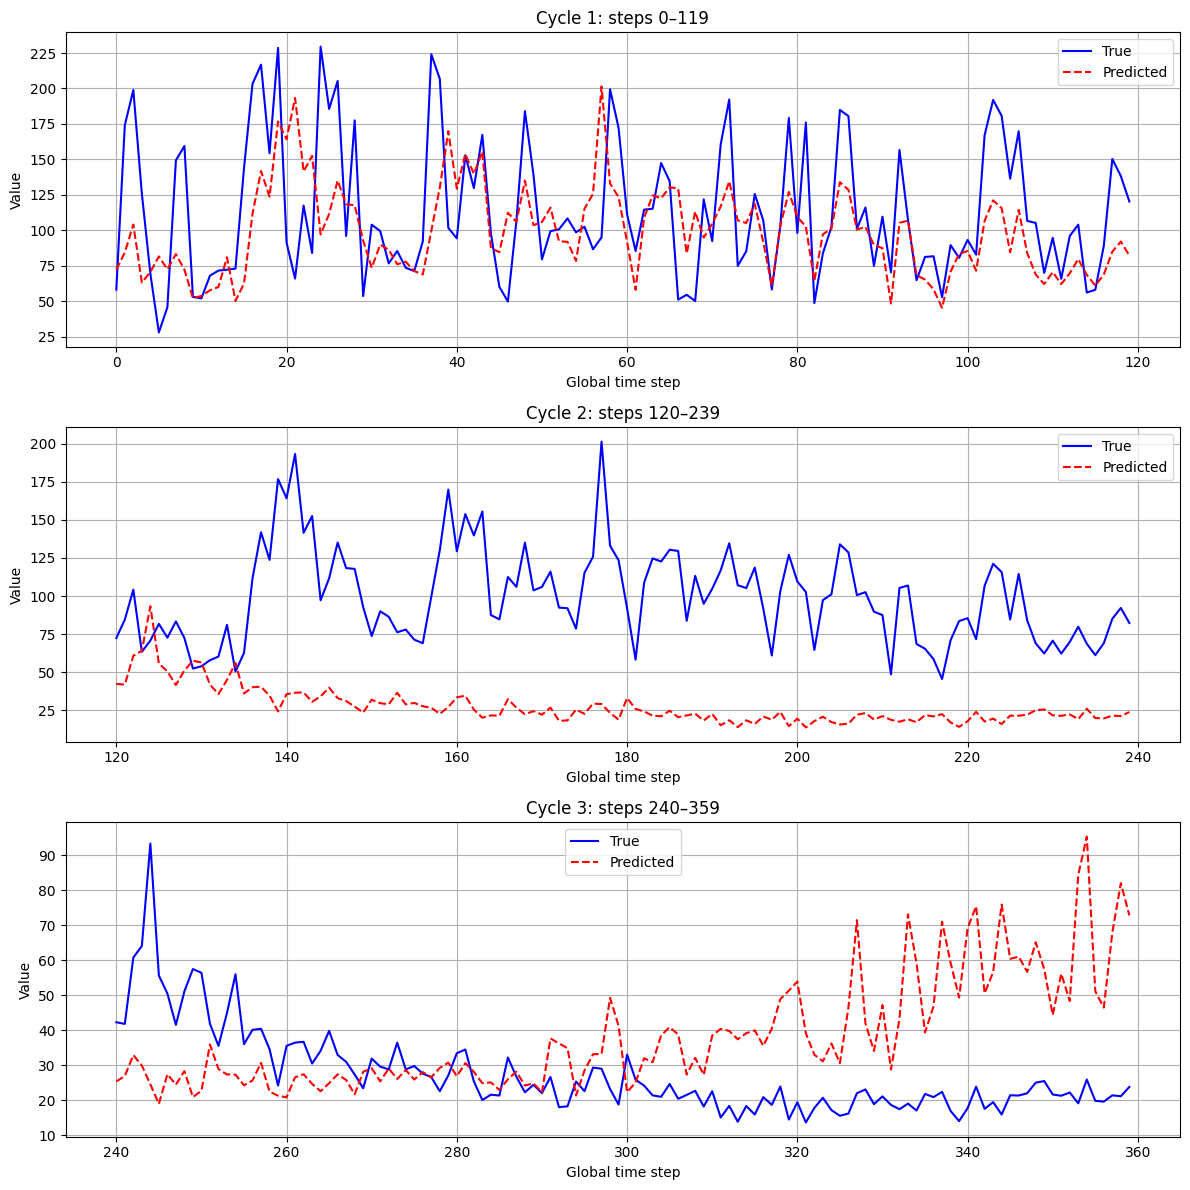

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_true = np.concatenate(y_true_lst)  # shape (360,)

# ─── 2) Compute metrics ───────────────────────────────────────────────────────
mse  = mean_squared_error(y_true, preds)
mae  = mean_absolute_error(y_true, preds)
mape = np.mean(np.abs((y_true - preds) / (y_true + 1e-8))) * 100

print(f"Overall MSE : {mse:.4f}")
print(f"Overall MAE : {mae:.4f}")
print(f"Overall MAPE: {mape:.2f}%")

# ─── 3) Plot each 120-step block ───────────────────────────────────────────────
n_cycles = len(y_true_lst)
plt.figure(figsize=(12, 4 * n_cycles))

for i in range(n_cycles):
    start = i * 120
    end   = start + 120

    plt.subplot(n_cycles, 1, i + 1)
    t = np.arange(start, end)

    plt.plot(t, y_true[start:end], 'b-', label='True')
    plt.plot(t, preds[start:end],   'r--', label='Predicted')
    plt.title(f'Cycle {i+1}: steps {start}–{end-1}')
    plt.xlabel('Global time step')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()